In [1]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd

In [2]:
data_full = pd.read_csv("./DF034.csv")
data_full_other = pd.read_csv("./DF12.csv")
data_full = pd.concat([data_full, data_full_other], ignore_index=True)

In [3]:
data_full['logSFRtot'] = np.log10(data_full['totalStarFormationRate'])

In [4]:
data_full['logmass'] = np.log10(data_full['stellar_mass'])

In [5]:
data_full['g']  = data_full['Mag_true_g_sdss_z0']
data_full['r']  = data_full['Mag_true_r_sdss_z0']
data_full['i']  = data_full['Mag_true_i_sdss_z0']
data_full['z']  = data_full['Mag_true_z_sdss_z0']

In [6]:
#data = data_full[['morphology/totalSersicIndex', 'size_true', 'Mag_true_i_sdss_z0',
#       'redshift', 'Mag_true_r_sdss_z0', 'Mag_true_g_sdss_z0',
#       'morphology/totalEllipticity',
#       'Mag_true_z_sdss_z0', 'stellar_mass','logmass']]

#from the working bijector sampling
data_full['g-r'] = data_full['g'] - data_full['r']
data_full['r-i'] = data_full['r'] - data_full['i']
data_full['i-z'] = data_full['i'] - data_full['z']

data = data_full[['redshift', 'logSFRtot', 'morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z']]

# standard scale the reference magnitude and colors
data = data.values
data[:, 2:] = (data[:, 2:] - data[:, 2:].mean(axis=0))/data[:, 2:].std(axis=0)
data = pd.DataFrame(data, columns=('redshift','logSFRtot','morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'))

In [7]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


#split into 100 chunks
data_list = split_dataframe(data, chunk_size=int(len(data)/1.e2))

data_subset = data.sample(n=int(len(data)/1.e2))

In [8]:
data_subset.head()

redshift  logSFRtot  morphology/totalSersicIndex  size_true  \
3433926   0.616277   9.120131                     0.863743   3.847482   
19777757  0.843164   4.879140                    -0.715746  -0.441436   
13772940  0.643815   5.468940                    -0.364665   0.400104   
20403800  0.958906   5.824145                     1.966394  -0.780452   
35673142  0.354796   4.771993                    -0.715746   0.178005   

           logmass         g         r         i         z       g-r  \
3433926   2.977665 -2.506457 -2.594329 -2.646646 -2.679472  0.795106   
19777757 -0.650221  0.009428  0.072263  0.100023  0.122207 -0.585012   
13772940  1.250285 -0.941003 -1.110901 -1.164770 -1.190065  1.573356   
20403800 -1.520848  0.793128  0.815872  0.816327  0.816952 -0.204458   
35673142 -0.405840  1.221367  1.027585  0.915936  0.848535  1.815713   

               r-i       i-z  
3433926   1.242326  1.706944  
19777757 -0.556811 -0.611511  
13772940  1.156689  1.034570  
20403800 -0.073083 -0.278379  
35673142  2.135938  1.466438

In [21]:
conditional_columns = data_subset.columns.drop(['redshift', 'logSFRtot'])
latent = Joint(Uniform([(-3,3)]), Normal(1))
means = np.array([0.5, data_subset['logSFRtot'].mean()])
stds = np.array([1/5.9, data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=10),
)
flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = ('morphology/totalEllipticity', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'),
    bijector = bijector,
    latent = latent,          
)

In [22]:
# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(['redshift', 'logSFRtot'], bijector, conditional_columns=data_subset.columns.drop(['redshift', 'logSFRtot']))

In [23]:
#%%time
losses = flow.train(data_subset, epochs=30, verbose=True)

Training 30 epochs 
Loss:
2.6108
-1.0316
-1.2080
-1.2513
-1.2892
-1.2946
-1.3427
-1.3537
-1.3871
-1.4136
-1.4383
-1.4435
-1.4395
-1.4374
-1.4344
-1.4667
-1.4545
-1.4663
-1.5049
-1.4964
-1.5110
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


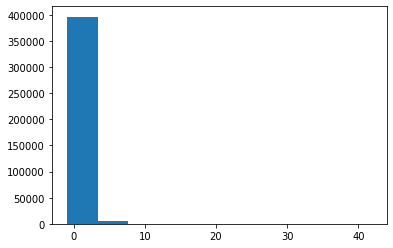

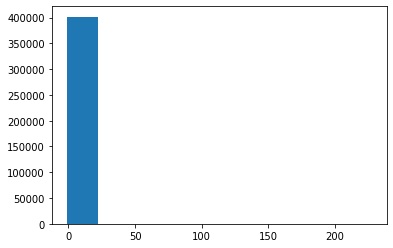

In [15]:
plt.hist(data_subset['size_true'])
plt.show()
plt.hist(data_list[0]['size_true'])
plt.show()

Text(0, 0.5, 'Training loss')

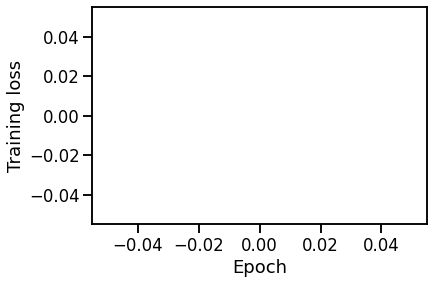

In [16]:
import seaborn as sns
sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("TrainingLoss_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [17]:
allSamples = []
for chunk in data_list:
    samples = flow.sample(1, conditions=chunk, seed=0)
    allSamples.append(samples)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-9e715ebae68b>", line 3, in <module>
    samples = flow.sample(1, conditions=chunk, seed=0)
  File "/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/pzflow-1.4.0-py3.7.egg/pzflow/normalizing_flow.py", line 442, in sample
    x = self._inverse(self._params[1], u, conditions=conditions)[0]
  File "/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/pzflow-1.4.0-py3.7.egg/pzflow/bijectors/bijectors.py", line 71, in __call__
    return self._func(params, inputs, **kwargs)
  File "/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/pzflow-1.4.0-py3.7.egg/pzflow/bijectors/bijectors.py", line 165, in inverse_fun
    return bijector_chain(params[::-1], inverse_funs[::-1], inputs, **kwargs)
  File "/Users/alexgagliano/miniconda3/lib/pyt


KeyboardInterrupt



In [ ]:
allSamples_DF = pd.concat(allSamples)
samples = allSamples_DF.copy()

In [ ]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values - data_full['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred} - z_{DC2}$");
#plt.savefig("zPred_vs_zDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(samples['redshift'], samples['logSFRtot'], 'o', ms=0.08)
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_pzFlowOnly.png",dpi=300, bbox_inches='tight')

In [ ]:
len(samples[samples['redshift']>1.0])/len(samples)*100

In [ ]:
len(samples[samples['redshift']<0.0])/len(samples)*100

In [ ]:
samples_small = samples[(samples['r'] < -2.) & (samples['r'] > -3.)]
data_full_small = data[(data['r'] < -2.) & (data['r'] > -3.)]

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(fontsize=16, loc='upper right')
#plt.savefig("SFR_vs_Redshift_pzFlow.png",dpi=300, bbox_inches='tight')

In [ ]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, c='k', label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justPZFlow.png",dpi=300, bbox_inches='tight')

In [ ]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justDC2.png",dpi=300, bbox_inches='tight')

In [ ]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values - data_full['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
plt.axvline(x=0, c='r')
plt.xlim((-3, 3))
plt.xlabel(r"$logSFRtot_{pred} - logSFRtot_{DC2}$");
#plt.savefig("SFRtotPred_vs_SFRtotDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$logSFRtot_{pred}$")
#plt.savefig("SFRtotPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
import seaborn as sns
sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred}$")
#plt.savefig("zPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [ ]:
#RUNNING UP TO HERE 03/07/2021!!

In [214]:
samples[['redshift', 'logSFRtot']].to_csv("samples_newRedshift_SFR.csv",index=False)

In [215]:
data_full['DC2redshift'] = data_full['redshift'].values
data_full['PZflowredshift'] = samples['redshift'].values

data_full['DC2SFRtot'] = 10**(data_full['logSFRtot'].values)
data_full['PZflowSFRtot'] = 10**(samples['logSFRtot'].values)

del data_full['redshift']
del data_full['logSFRtot']

In [219]:
data_full_save = data_full[['galaxy_id','ra','dec',
          'DC2redshift',
          'PZflowredshift',
          'z_bin',
          'Mag_true_g_sdss_z0',
          'Mag_true_r_sdss_z0',
          'Mag_true_i_sdss_z0',
          'Mag_true_z_sdss_z0', 
          'morphology/totalSersicIndex',
          'size_true',
          'morphology/totalEllipticity',
          'stellar_mass',
          'DC2SFRtot', 
          'PZflowSFRtot']]

In [221]:
#truncate for quality cuts
data_full_save_cut = data_full_save[(data_full_save['PZflowredshift']>=0.0) & (data_full_save['PZflowredshift']<=1.0)]

In [47]:
data_full_save_cut = data_full_save_cut[(data_full_save_cut['PZflowSFRtot'] > 1.e1) & (data_full_save_cut['PZflowSFRtot'] < 1.e10)]

In [64]:
data_full_save_cut.to_csv("./DC2_pzRedshifts_SFR.csv",index=False)

In [68]:
len(data_full_save_cut)/len(data_full)

0.9941790124752233

In [43]:
samples.to_csv("./samples_conditionalRedshift.csv",index=False)

In [42]:
#re-load data
data_full_save_cut = pd.read_csv("./DC2_pzRedshifts_SFR.csv", low_memory=True)

In [40]:
logSFR_data = np.log10(data_full_save_cut['DC2SFRtot'].sample(n=5000))
logSFR_samples = np.log10(data_full_save_cut['PZflowSFRtot'].sample(n=5000))

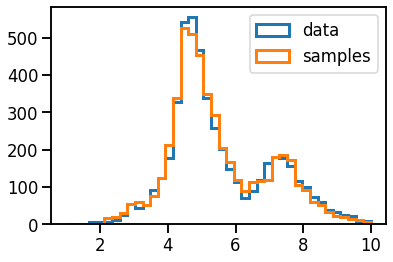

In [61]:
plt.hist(logSFR_data, range=(1, 10),bins=40,  histtype='step', label='data',lw=3)
plt.hist(logSFR_samples, range=(1, 10),bins=40,  histtype='step', label='samples',lw=3)
plt.legend()
plt.savefig("SFR_conditionalSampling.png",dpi=200, bbox_inches='tight')

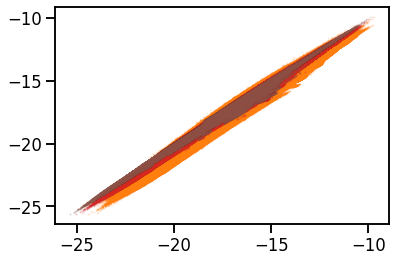

In [63]:
#truncate a few more outliers
import numpy as np 
for band in ['Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0']:
    m, b = np.polyfit(data_full_save_cut[band], data_full_save_cut['Mag_true_z_sdss_z0'], 1)
    samples_outliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) > 1.3]
    samples_inliers = data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]
    plt.plot(samples_outliers[band], samples_outliers['Mag_true_z_sdss_z0'], 'o', ms=2)
    plt.plot(samples_inliers[band], samples_inliers['Mag_true_z_sdss_z0'], 'o', ms=1, alpha=0.1)

    data_full_save_cut =  data_full_save_cut[np.abs((m*data_full_save_cut[band] + b) - data_full_save_cut['Mag_true_z_sdss_z0']) < 1.3]

In [49]:
plt.hist(data['redshift'], range=(0, 1.0), bins=40, histtype='step', label='data')
plt.hist(samples['redshift'], range=(0, 1.0), bins=40, histtype='step', label='samples')
plt.legend()
plt.savefig("Histogram_z_allProperties_ConditionalZSFR.png",dpi=200)

NameError: name 'data' is not defined

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

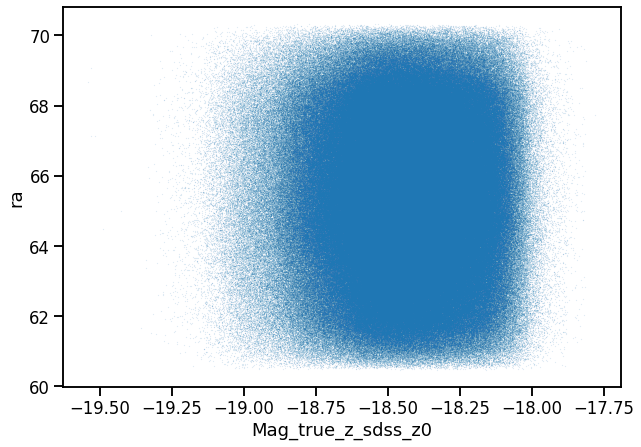

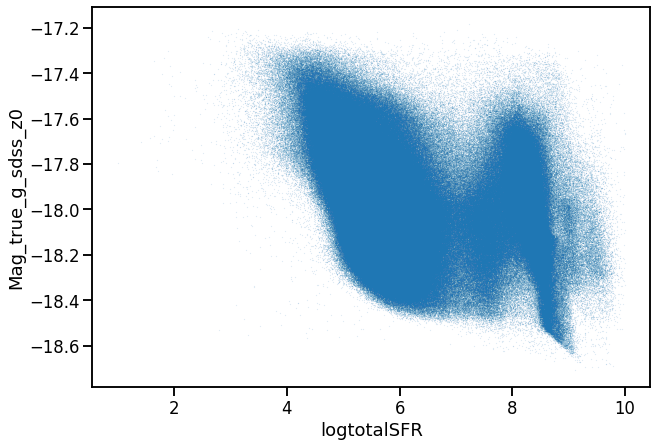

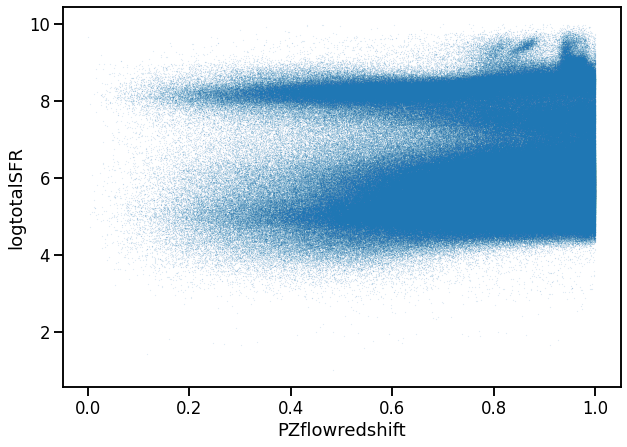

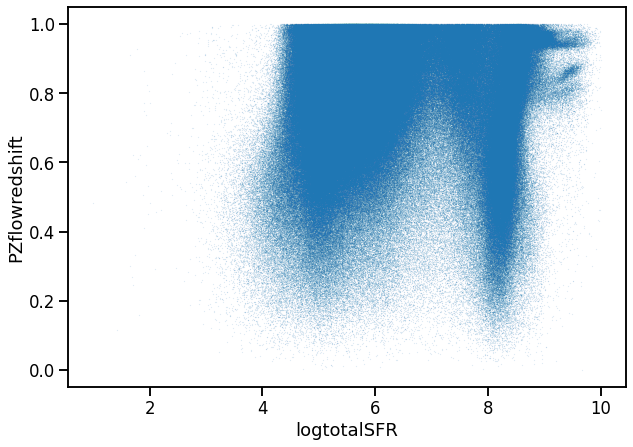

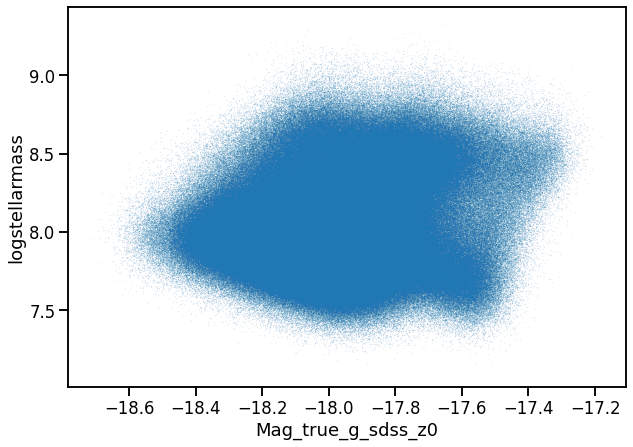

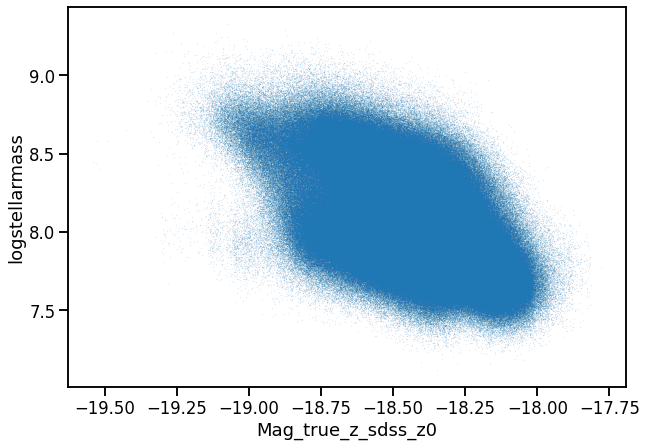

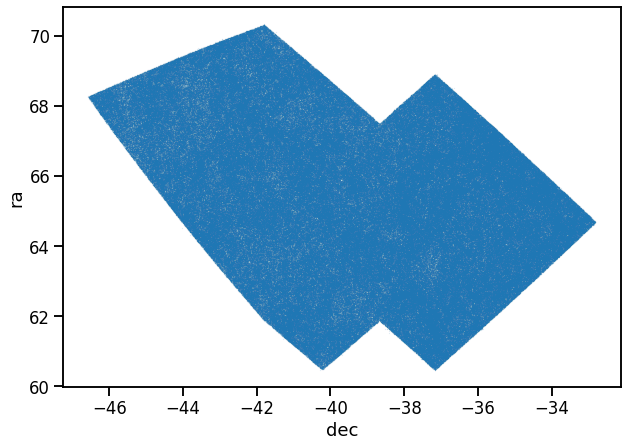

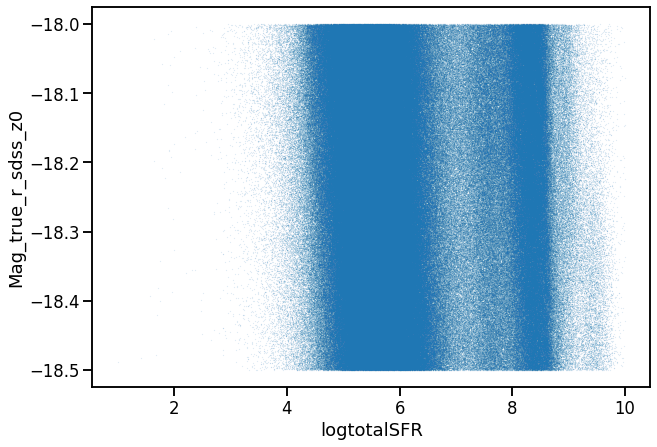

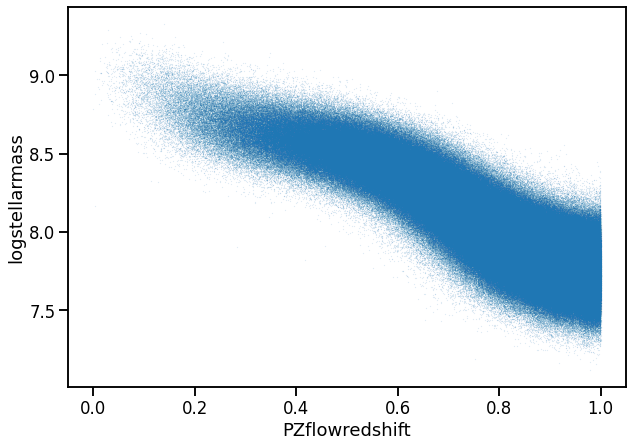

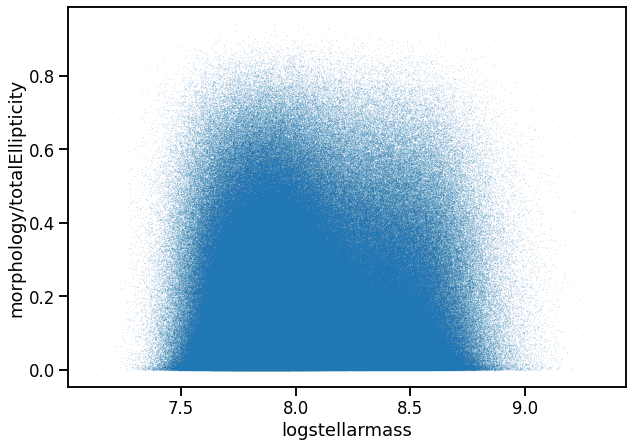

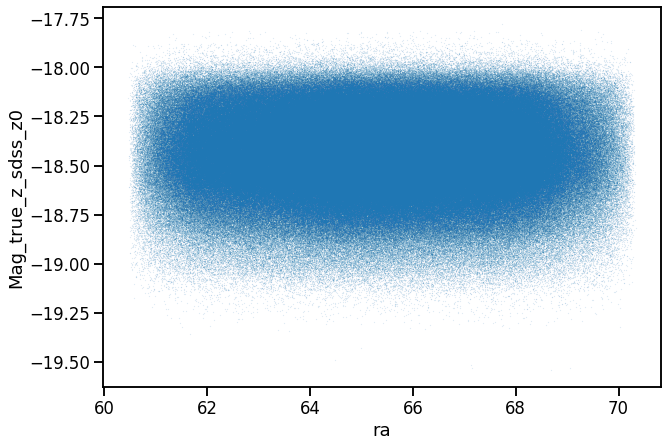

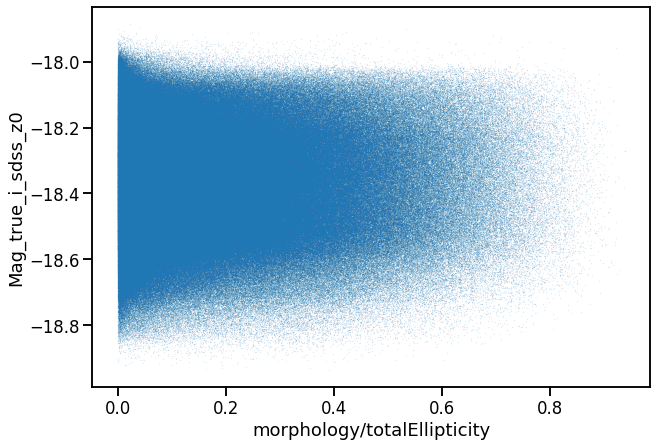

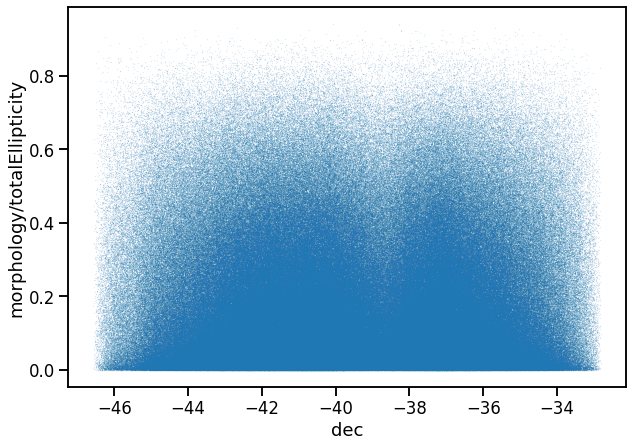

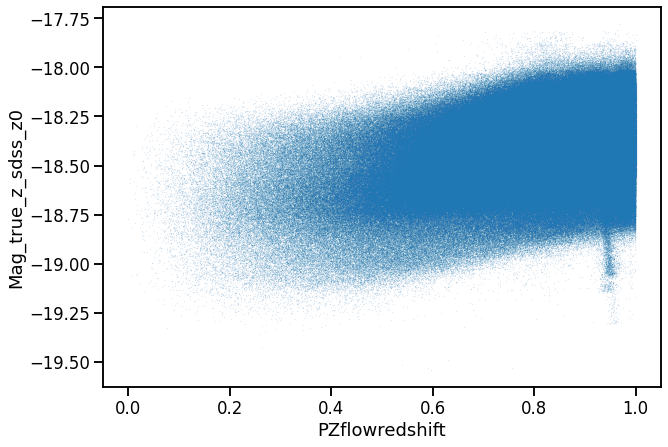

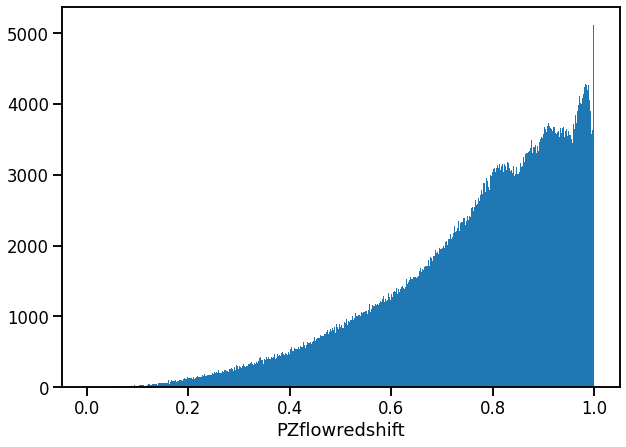

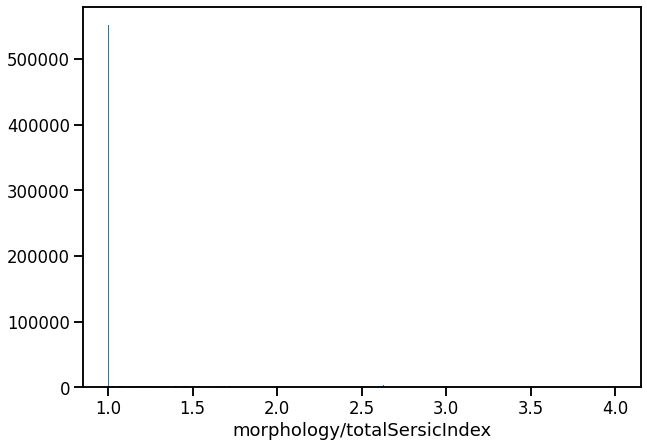

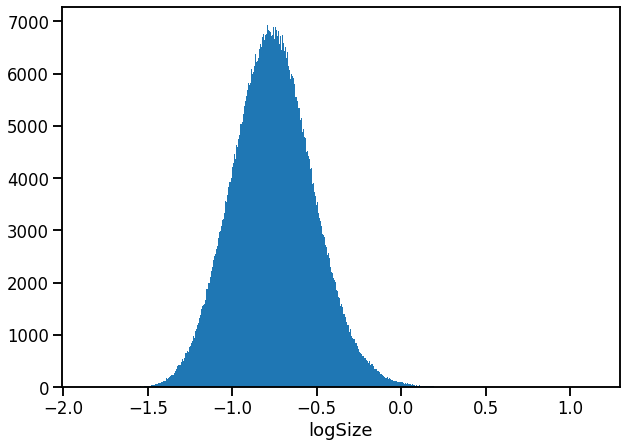

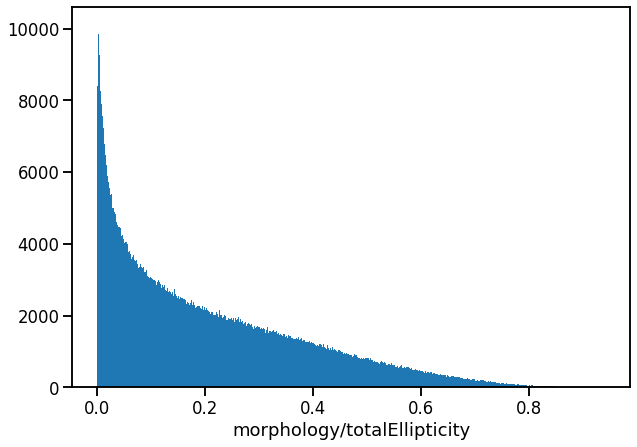

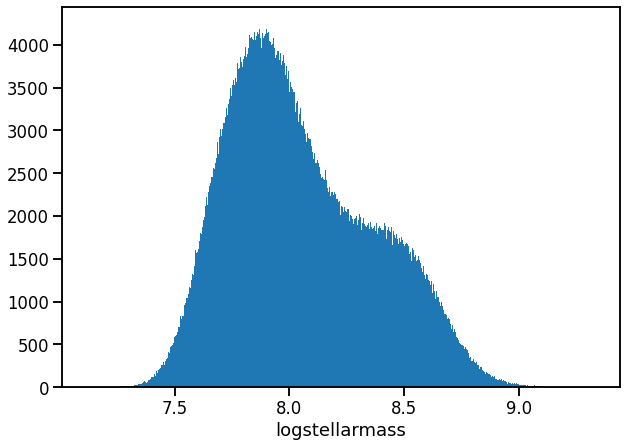

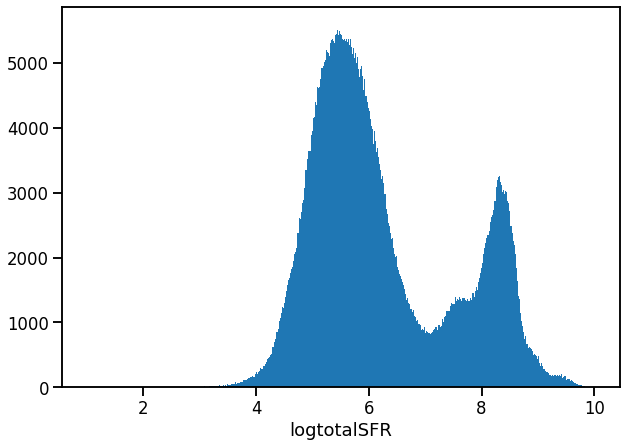

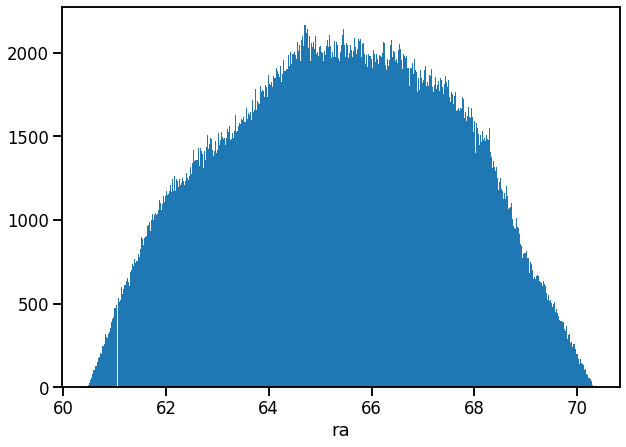

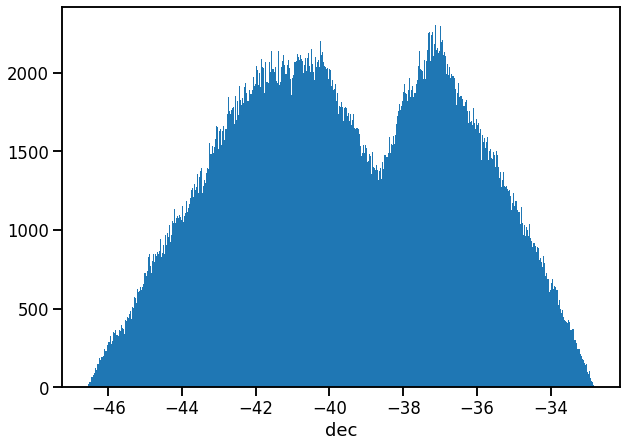

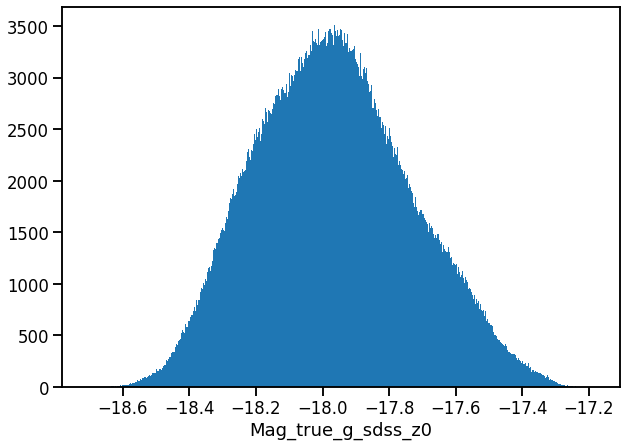

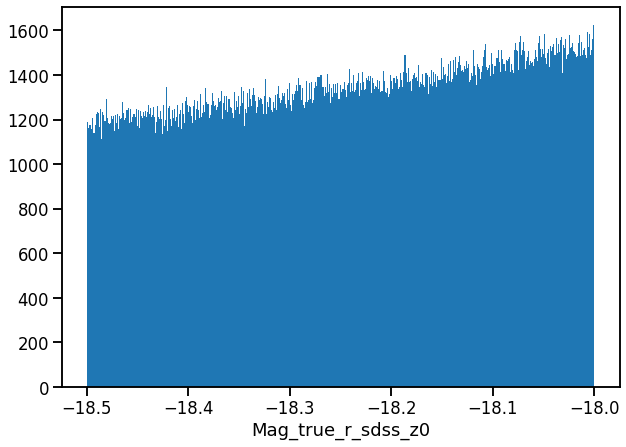

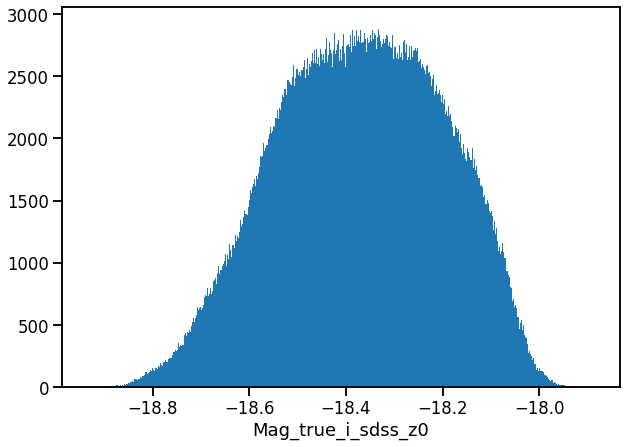

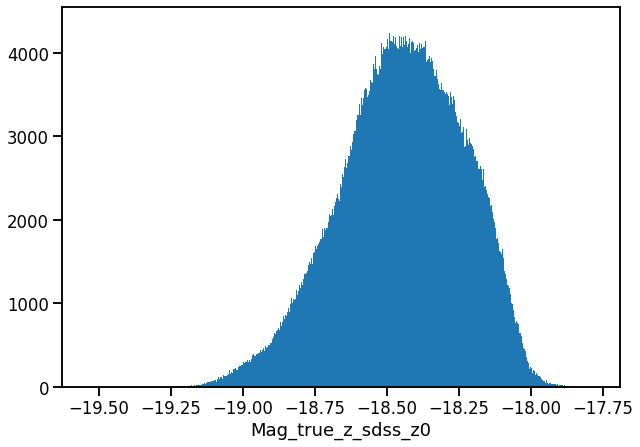

In [60]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])

params = ['PZflowredshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
data_cut = data_cut[params]

for i in np.arange(15):
    idx1 = random.randint(0, len(params)-1)
    idx2 = random.randint(0, len(params)-1)
    if idx1 == idx2:
        continue
    plt.figure(figsize=(10,7))
    plt.plot(data_cut[params[idx1]], data_cut[params[idx2]],'o',ms=0.05)
    plt.xlabel(params[idx1])
    plt.ylabel(params[idx2])
    plt.show()

for i in np.arange(len(params)):
    vals = data_cut[params[i]]
    vals.replace([np.inf, -np.inf], np.nan, inplace=True) #drop inf
    vals = vals[vals == vals] #drop na
    plt.figure(figsize=(10,7))
    plt.hist(vals, bins=int(1.e3))
    plt.xlabel(params[i])

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

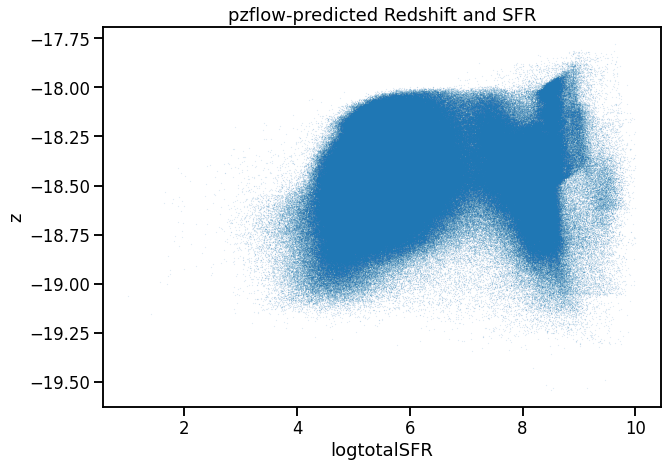

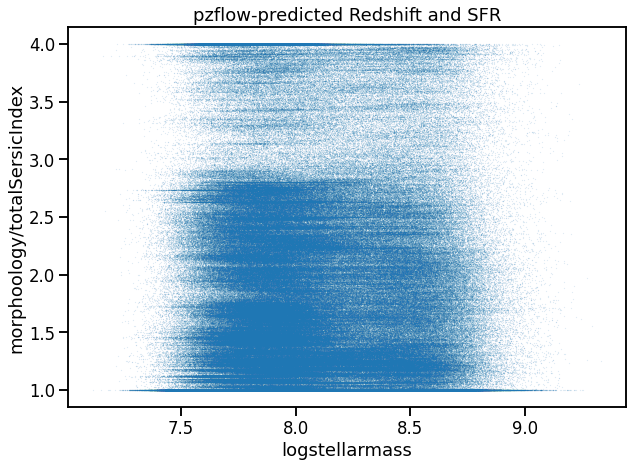

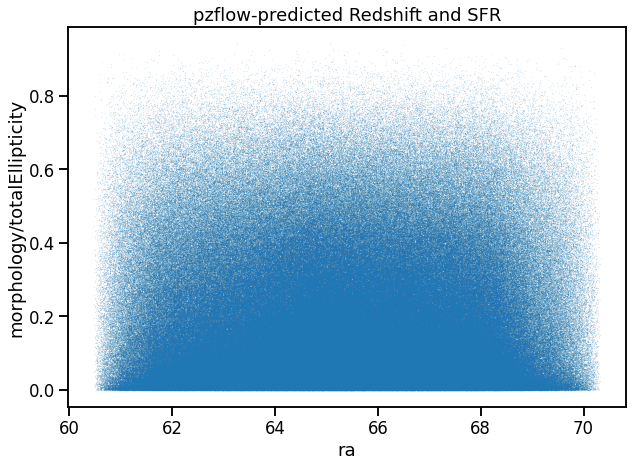

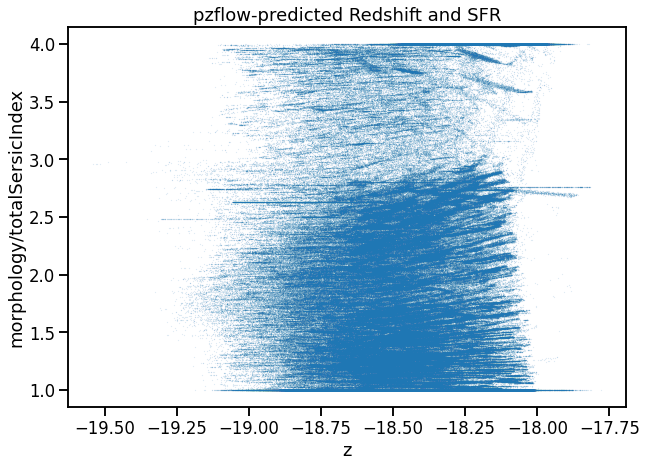

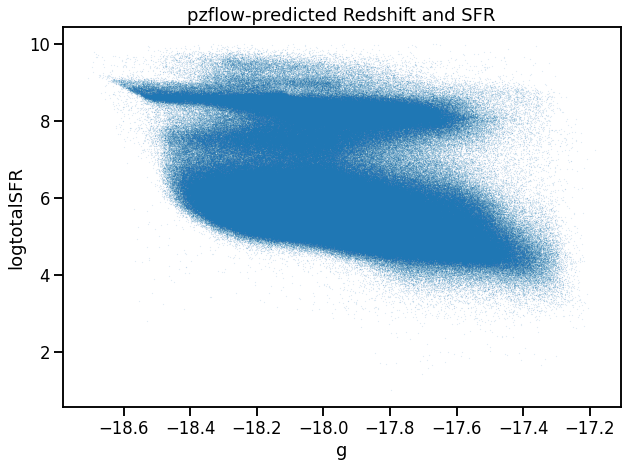

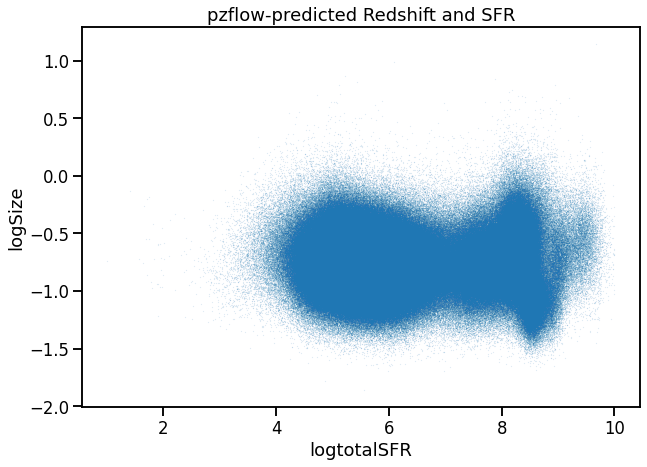

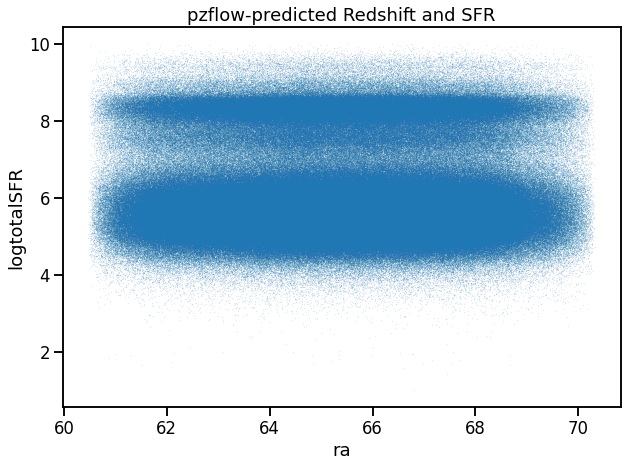

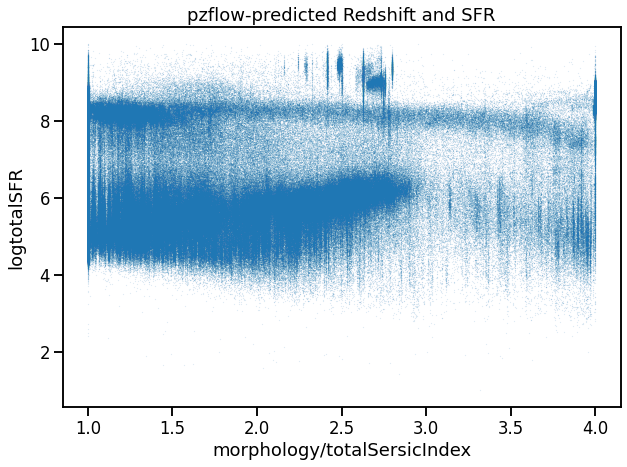

In [55]:
import seaborn as sns
import random
data_cut = data_full_save_cut[(data_full_save_cut['Mag_true_r_sdss_z0'] < -18) & ((data_full_save_cut['Mag_true_r_sdss_z0'] > -18.5))]
sns.set_context("talk")

data_cut['logstellarmass'] = np.log10(data_cut['stellar_mass'])
data_cut['logtotalSFR'] = np.log10(data_cut['PZflowSFRtot'])
data_cut['logSize'] = np.log10(data_cut['size_true'])
data_cut['g'] = data_cut['Mag_true_g_sdss_z0']
data_cut['r'] = data_cut['Mag_true_r_sdss_z0']
data_cut['i'] = data_cut['Mag_true_i_sdss_z0']
data_cut['z'] = data_cut['Mag_true_z_sdss_z0']

params = ['PZflowredshift', 'DC2redshift', 'morphology/totalSersicIndex','logSize',
          'morphology/totalEllipticity','logstellarmass','logtotalSFR','ra','dec', 'g', 'r', 'i', 'z']
data_cut = data_cut[params]

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['z'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("z")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logstellarmass'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("logstellarmass")
plt.ylabel("morphoology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['morphology/totalEllipticity'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("morphology/totalEllipticity")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['z'], data_cut['morphology/totalSersicIndex'],'o',ms=0.05)
plt.xlabel("z")
plt.ylabel("morphology/totalSersicIndex")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['g'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("g")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['logtotalSFR'], data_cut['logSize'],'o',ms=0.05)
plt.xlabel("logtotalSFR")
plt.ylabel("logSize")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['ra'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("ra")
plt.ylabel("logtotalSFR")
plt.show()

plt.figure(figsize=(10,7))
plt.title("pzflow-predicted Redshift and SFR")
plt.plot(data_cut['morphology/totalSersicIndex'], data_cut['logtotalSFR'],'o',ms=0.05)
plt.xlabel("morphology/totalSersicIndex")
plt.ylabel("logtotalSFR")
plt.show()